# Introduction to HNAM

In [4]:
import numpy as np
import pandas as pd
import torch
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import torch
from torch import nn
from pytorch_forecasting import TimeSeriesDataSet,EncoderNormalizer,GroupNormalizer,HNAM,NaNLabelEncoder,RMSE
from lightning.pytorch.callbacks import ModelCheckpoint
from matplotlib import colormaps
import os

colormap = colormaps.get_cmap('Dark2')
def add_month(date):
    if date.month == 12:
        return date.replace(year=date.year+1, month=1, day=1)
    else:
        return date.replace(month=date.month+1, day=1)
    

def plot_fc(data,actuals,ts=0,tidx=0,history=10,benchmarks=True,benchmark_models=['tft'],f=7):


    ts_data = data[(data['time_series'] == ts) & (data['time_idx'] == tidx)]
    ts_data = ts_data.set_index('pred_idx')

    actual_data = actuals[(actuals['time_series'] == ts ) & (actuals['time_idx'] <= ts_data.index.max()) & (actuals['time_idx'] >= ts_data.index.min() - history)].set_index('time_idx')

    x_level = ts_data['effect_x_level']
    x_weekday = ts_data['effect_weekday']
    causals = ts_data.columns[(ts_data.columns.str.contains('effect')) & ~(ts_data.columns.str.contains('effect_x_level')) & ~(ts_data.columns.str.contains('effect_weekday'))]
    causalnames = [c.split('_')[1].capitalize() for c in causals]

    sel = ts_data[causals].abs().rank(axis=1,method='first',ascending=False).melt(ignore_index=False).pivot_table(index='pred_idx', columns='value', values='variable',aggfunc='first')
    effects = sel.copy()
    for index,values in sel.iterrows():
        effects.loc[index] = ts_data.loc[index,values.values].values

    effects_cum = effects.copy()
    effects_cum = effects_cum.cumsum(axis=1).shift(1,axis=1)

    colors = list(colormap.colors)
    colors.pop(1)

    fig = plt.figure(figsize=(15,5),dpi=200)
    plt.plot( actual_data['sales'],label='Actual',color='red')

    if benchmarks:
        for bm in benchmark_models:
            plt.plot(ts_data[bm],label=bm.upper(),linestyle='--',color=colors.pop(0))



    plt.plot(ts_data['pred'],label='HNAM',color='black',linestyle='--')

    rmse = np.sqrt(np.mean((ts_data['pred'] - actual_data['sales'])**2))
    smape = 1/len(actual_data) * np.sum(2 * np.abs(ts_data['pred'] - actual_data['sales']) / (np.abs(ts_data['pred']) + np.abs(actual_data['sales'])))

    plt.plot(ts_data.index,ts_data['effect_x_level'],label='Level',color='lightblue',alpha=0.7)
    plt.bar(x = effects.index + np.where(x_weekday > 0,0.04,-0.04), height = x_weekday.values, bottom = x_level,width=0.15,label='Weekday',color=colors.pop(0))
    for causal,causalname,color in zip(causals,causalnames,colors):
        mask = sel[sel==causal].notnull()
        bottoms = effects_cum[mask].fillna(0).sum(axis=1)
        bottoms = bottoms + x_level + x_weekday
        causal_effects = effects[mask].fillna(0).sum(axis=1)
        plt.bar(x = effects.index + np.where(causal_effects > 0,0.04,-0.04), height = causal_effects.values, bottom = bottoms,width=0.15,alpha=0.7,label=causalname,color=color)


    plt.xticks(actual_data.index[::f])
    plt.legend()
    plt.grid(color='black', linestyle='-', linewidth=0.1)
    plt.xlabel('Time Index')
    plt.ylabel('Sales')

    title_x = 0.18
    title_y = 0.95
    delta_y = 0.05
    plt.text(title_x, title_y, f'Time Series {ts}', ha='left', va='center', fontsize=12, weight='bold', transform=plt.gca().transAxes)
    plt.text(title_x, title_y - delta_y, f'HNAM RMSE: {rmse:.2f},   SMAPE: {smape:.2f}', ha='left', va='center', fontsize=10, transform=plt.gca().transAxes)

    plt.show()

In [5]:
np.random.seed(0)
torch.manual_seed(0)

if torch.cuda.is_available():
    ACC = 'gpu'         
    NW = os.cpu_count()    
    DEVICES = int(os.environ.get('DEVICES',1))
    torch.set_float32_matmul_precision('medium')
    STRATEGY = 'auto' if DEVICES==1 else 'ddp'
else:
    # ACC = 'mps'  # < this is for mac m chip users, otherwise use os.cpu_count()
    ACC = 'cpu'
    DEVICES = 1
    NW = 0  # < this is for mac m chip users, otherwise use os.cpu_count()
    # NW = os.cpu_count()
    STRATEGY = 'auto'


print(f'Using {NW} threads')
print(f'Using {DEVICES} accelerators')

LIMIT_TS = 5  # limit the number of time series used for this introduction

LR = 1e-3   # learning rate
WD = 1e-2   # weight decay
BS = 128    # batch size
RLRP = 10   # reduce on plateau patience
EPOCHS = 30 # maximum number of epochs, set low for this introduction, vary if you like
PATIENCE = 10 # patience for early stopping
PTFC_MODEL = HNAM
LOSS = RMSE(quantiles=[0.5])

holiday = ['Sporting', 'Cultural', 'National']
MODEL_KWARGS = dict(base=           ['time_idx','relative_time_idx','art','pos','doy_sine','doy_cosine'],
                    causal=         ['weekday', 'relprice','snap']+holiday,
                    trend_query  =  ['time_idx','relative_time_idx','art','pos','doy_sine','doy_cosine'],
                    cov_emb=8,trend_emb=4,factor=4,attention=True,att_proj='cnn')
                # model hyperparameters set to a relatively sparse model for this introduction

# data
DATASET = 'Walmart'

# dataset
pred_length = 14
val_length = 30
test_length = 30
enc_len = 14


df = pd.read_pickle(f'../hnam_experiments/Processed/{DATASET}/{DATASET.lower()}_data.pkl')

ds_kwargs = dict(
    static_categoricals=['art','pos'],
    time_varying_unknown_reals=['sales'],
    time_varying_known_reals=['time_idx','relprice','doy_sine','doy_cosine'],
    time_varying_known_categoricals=['weekday','snap']+holiday,
    categorical_encoders = {h: NaNLabelEncoder(add_nan=False).fit(df[h]) for h in holiday},
    target_normalizer = GroupNormalizer(groups=['time_series']),
    scalers = {'price': GroupNormalizer(groups=['time_series']),
               'relprice':EncoderNormalizer('identity')})


if LIMIT_TS:
    sel = list(df.groupby('time_series')['sales'].sum().sort_values(ascending=False).index)[:LIMIT_TS]
    df = df[df['time_series'].isin(sel)]
time_idxs = df['time_idx'].unique()


dtot = df[['time_idx','date']].drop_duplicates().set_index('date')['time_idx']
dtot = dtot.asfreq('D').bfill().to_dict()
ttod = {v:k for k,v in dtot.items()} 
test_date = pd.to_datetime('2016-01-01')
test_end = pd.to_datetime('2016-02-01')
train_end = dtot[test_date] -1

df_train = df[df['time_idx'] <= train_end - val_length]
df_val = df[(df['time_idx'] > train_end - val_length - enc_len) & (df['time_idx'] <= train_end)]
df_test = df[(df['time_idx'] > train_end - enc_len) & (df['date'] < test_end)]


Using 0 threads
Using 1 accelerators


In [6]:
ds_train = TimeSeriesDataSet(df,
                        target='sales',
                        group_ids=['time_series'],
                        time_idx='time_idx',
                        min_encoder_length=enc_len,
                        max_encoder_length=enc_len,
                        min_prediction_length=pred_length,
                        max_prediction_length=pred_length,
                        time_varying_unknown_categoricals=[],
                        add_relative_time_idx=True,
                        allow_missing_timesteps=True,
                        scale_target=True,
                        **ds_kwargs
                        )

ds_val = TimeSeriesDataSet.from_dataset(ds_train, df_val, stop_randomization=True,scale_target=True)
ds_test = TimeSeriesDataSet.from_dataset(ds_train, df_test, stop_randomization=True,scale_target=False)
                        
dl_train = ds_train.to_dataloader(train=True,num_workers = NW)
dl_val = ds_val.to_dataloader(train=False,num_workers = NW)
dl_test = ds_test.to_dataloader(train=False,num_workers = NW)

model = PTFC_MODEL.from_dataset(ds_train,loss=LOSS,learning_rate=LR,weight_decay=WD,**MODEL_KWARGS,reduce_on_plateau_patience=RLRP)
model.rescale_off()

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename='model-{epoch:02d}-{val_loss:.2f}',  # Save the model with the epoch number and the validation metric
    save_top_k=1,  # Save only the best model
    mode='min',  # The best model is the one with the lowest validation SMAPE
    auto_insert_metric_name=False,  # Prevent prepending monitored metric name to the filename
)

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=PATIENCE,
    verbose=True,
    mode="min",
)

trainer = pl.Trainer(
    max_epochs= EPOCHS,
    accelerator=ACC,
    devices=DEVICES,  
    strategy=STRATEGY,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback, checkpoint_callback],
)

trainer.fit(model, dl_train,val_dataloaders=dl_val)
best_model_path = trainer.checkpoint_callback.best_model_path
model = PTFC_MODEL.load_from_checkpoint(best_model_path)
model.rescale_on()

raw = model.predict(dl_test, mode="raw", return_x=True, return_index=True)
index = raw.index
preds = raw.output.prediction
dec_len = preds.shape[1]
n_quantiles = preds.shape[-1]
covs = list(raw.output.keys()[1:])
quantiles = None

preds_df = pd.DataFrame(index.values.repeat(dec_len * n_quantiles, axis=0),columns=index.columns)
preds_df = preds_df.assign(h=np.tile(np.repeat(np.arange(1,1+dec_len),n_quantiles),len(preds_df)//(dec_len*n_quantiles)))
preds_df = preds_df.assign(q=np.tile(np.arange(n_quantiles),len(preds_df)//n_quantiles))
preds_df['pred_idx'] = preds_df['time_idx'] + preds_df['h'] - 1
if quantiles is not None:
    preds_df['q'] = preds_df['q'].map({i:q for i,q in enumerate(quantiles)})
elif preds_df.q.nunique() == 1:
    preds_df = preds_df.drop(columns=['q'])
preds_df['pred'] = preds.flatten().cpu()

for k in covs:
    preds_df['effect_'+k] = raw.output[k].flatten().cpu()


/Users/leif/miniforge3/envs/tfc-dev/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/leif/miniforge3/envs/tfc-dev/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/leif/miniforge3/envs/tfc-dev/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(acc

Sanity Checking: 0it [00:00, ?it/s]

/Users/leif/miniforge3/envs/tfc-dev/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/leif/miniforge3/envs/tfc-dev/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 147/147 [00:20<00:00,  7.30it/s, v_num=2, train_loss_step=1.020, val_loss=1.010, train_loss_epoch=1.160]

Metric val_loss improved. New best score: 1.014


Epoch 2: 100%|██████████| 147/147 [00:19<00:00,  7.53it/s, v_num=2, train_loss_step=0.840, val_loss=0.988, train_loss_epoch=0.840]

Metric val_loss improved by 0.026 >= min_delta = 0.0001. New best score: 0.988


Epoch 5: 100%|██████████| 147/147 [00:19<00:00,  7.42it/s, v_num=2, train_loss_step=0.789, val_loss=0.974, train_loss_epoch=0.779]

Metric val_loss improved by 0.014 >= min_delta = 0.0001. New best score: 0.974


Epoch 6: 100%|██████████| 147/147 [00:20<00:00,  7.34it/s, v_num=2, train_loss_step=0.672, val_loss=0.971, train_loss_epoch=0.768]

Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.971


Epoch 7: 100%|██████████| 147/147 [00:20<00:00,  7.29it/s, v_num=2, train_loss_step=0.839, val_loss=0.968, train_loss_epoch=0.761]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.968


Epoch 8:  71%|███████   | 104/147 [00:14<00:05,  7.33it/s, v_num=2, train_loss_step=0.797, val_loss=0.968, train_loss_epoch=0.761]

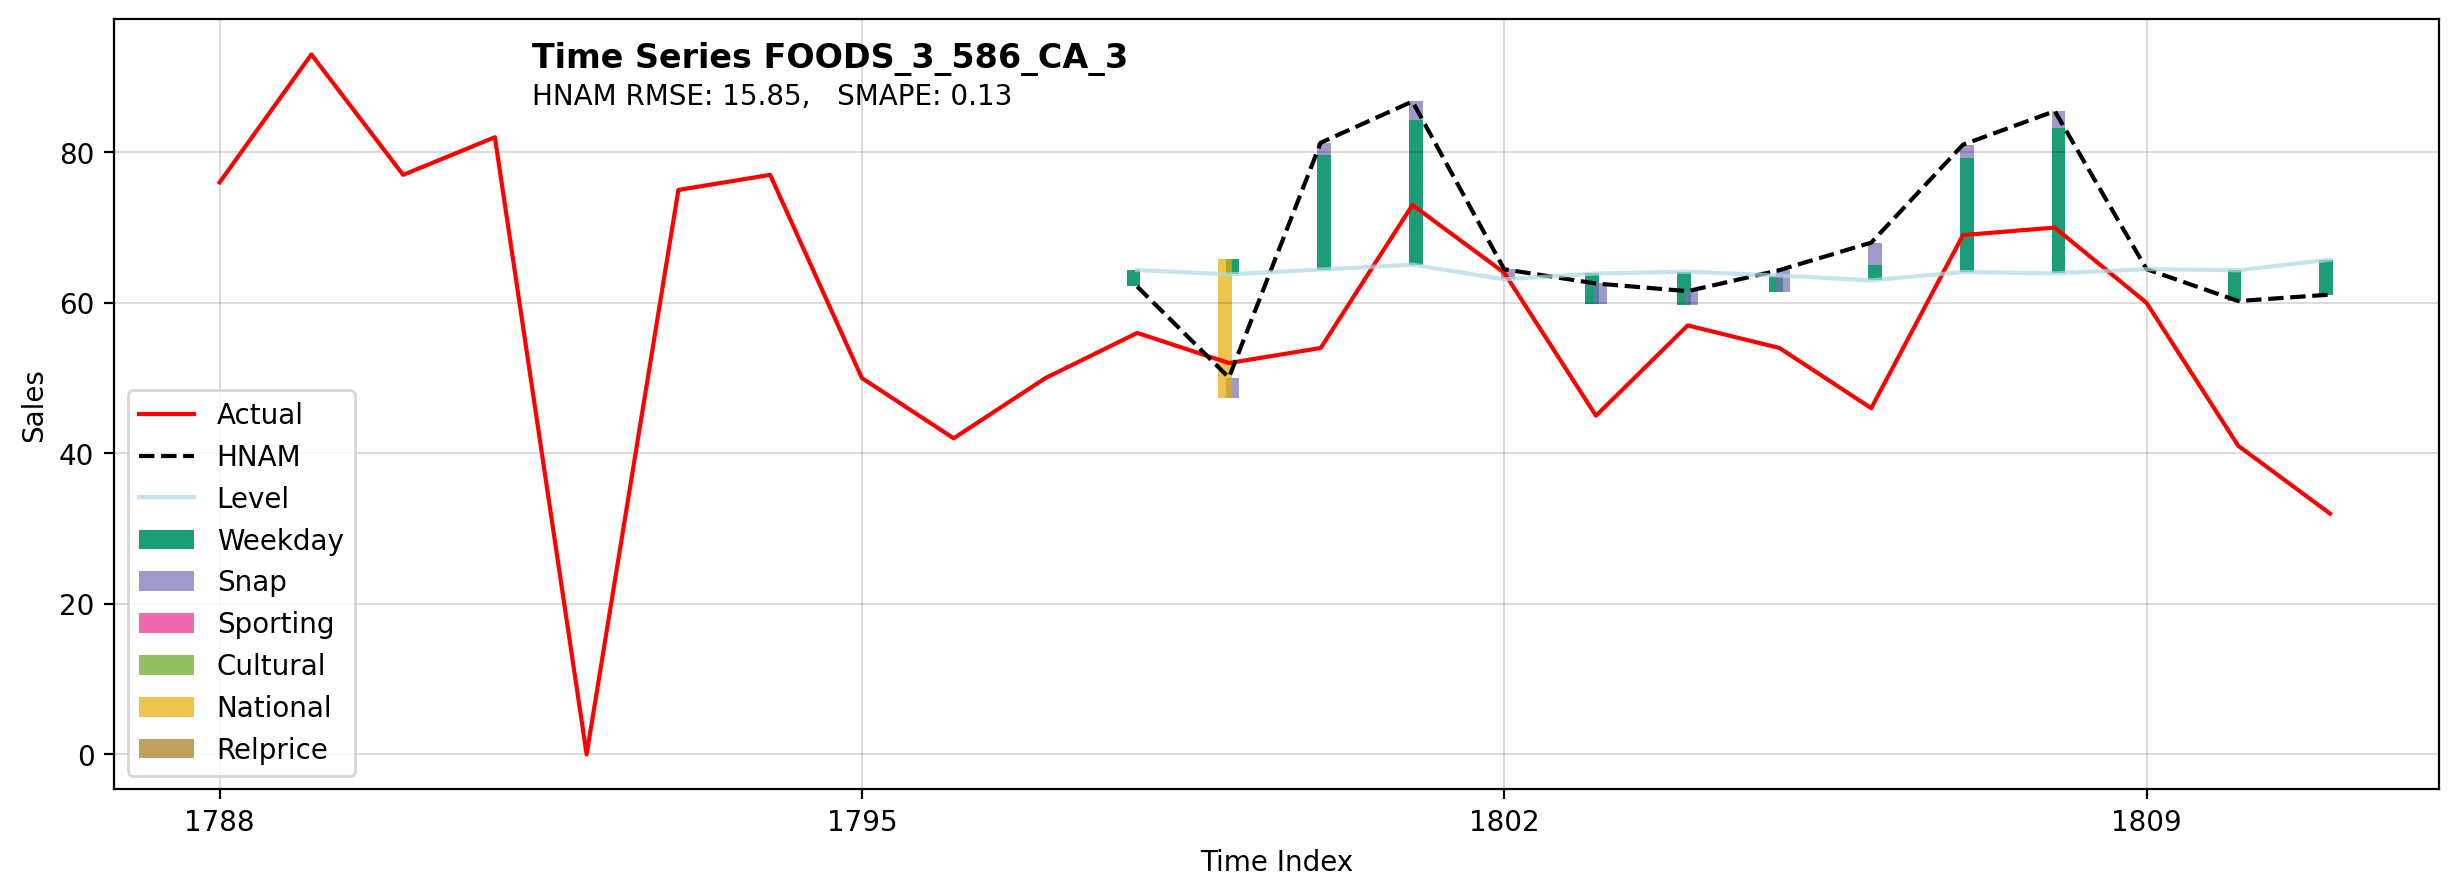

In [ ]:
# select the timeseries to display
ts_sel = 0
# select the time index, i.e. the first forecast time index, to display
idx_sel = 30
ts = preds_df['time_series'].unique()[ts_sel]
idx = preds_df['time_idx'].unique()[idx_sel]
plot_fc(preds_df,df,ts,idx,benchmarks=False,f=7,history=10)